In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
import matplotlib.dates as dts
import fredpy as fp
import pandas as pd
import runProcs
%matplotlib inline

In [2]:
# 0. Setup: Formatting commands and definitions.

# 0.1 general plot settings

# Make all plotted axis lables and tick lables bold 15 pt font
font = {'weight' : 'bold',
        'size'   : 15}
axes={'labelweight' : 'bold'}
plt.rc('font', **font)
plt.rc('axes', **axes)

# Add some space around the tick lables for better readability
plt.rcParams['xtick.major.pad']='8'
plt.rcParams['ytick.major.pad']='8'

# 0.2 Formatter for inserting commas in y axis labels with magnitudes in the thousands

def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:0,d}'.format(int(x))
   return s

y_format = plt.FuncFormatter(func)  # make formatter

# 0.3 format the x axis ticksticks
years2,years4,years5,years10,years15= dts.YearLocator(2),dts.YearLocator(4),dts.YearLocator(5),dts.YearLocator(10),dts.YearLocator(15)


# 0.4 label locator for vertical axes plotting gdp
majorLocator_y   = plt.MultipleLocator(3)
majorLocator_shares = plt.MultipleLocator(0.2)

# 0.5 load fred api key
fp.api_key = fp.load_api_key('fred_api_key.txt')

In [3]:
# 1. Setup for the construction of K and A

# 1.1 Parameters for the model
alpha = 0.35

# If output_solow == TRUE, then Y = C + I.  Else: Y = C + I + G + NX (default)
output_solow = False

# 1.3 Define the function for computing the capital series

def capitalSeries(i,k0,delta):
    t0 = len(i)-1
    k = [k0]
    for t in range(t0):
        k.append(i[t]+(1-delta)*k[t])

    return np.array(k)

In [4]:
# 2. Import and manage data from FRED

# 2.1 Annual data
investmentA = fp.series('GPDIA')
consumptionA = fp.series('PCECA')
governmentA = fp.series('GCEA')
exportsA = fp.series('EXPGSA')
importsA = fp.series('IMPGSA')
netExportsA = fp.series('A019RC1A027NBEA')
deflatorA = fp.series('A191RD3A086NBEA')
depreciationA = fp.series('Y0000C1A027NBEA')
gdpA = fp.series('GDPA')
tfpA = fp.series('GDPA')
capitalA = fp.series('GDPA')
laborA = fp.series('B4701C0A222NBEA')# BEA index: fred('HOANBS') / .quartertoannual(method='AVG')

# annualfp.series = [investmentA,consumptionA,governmentA,exportsA,importsA,netExportsA,deflatorA,depreciationA,gdpA,tfpA,capitalA,laborA]
investmentA,consumptionA,governmentA,netExportsA,exportsA,importsA,deflatorA,depreciationA,gdpA,tfpA,capitalA,laborA = fp.window_equalize([investmentA,consumptionA,governmentA,netExportsA,exportsA,importsA,deflatorA,depreciationA,gdpA,tfpA,capitalA,laborA])

# 2.2 Compute real annual data fp.series
investmentA.data= 100*investmentA.data/deflatorA.data
consumptionA.data = 100*consumptionA.data/deflatorA.data
governmentA.data = 100*governmentA.data/deflatorA.data
exportsA.data = 100*exportsA.data/deflatorA.data
importsA.data = 100*importsA.data/deflatorA.data
netExportsA.data = 100*netExportsA.data/deflatorA.data
gdpA.data= 100*gdpA.data/deflatorA.data
TA     = len(investmentA.data)

# 2.3 Convert labor from millions of hours to billions
laborA.data = laborA.data/1000

# 2.4 Quarterly data
investmentQ  = fp.series('GPDI')
investmentQ4  = fp.series('GPDI')
consumptionQ  = fp.series('PCEC')
governmentQ = fp.series('GCE')
exportsQ = fp.series('EXPGS')
importsQ = fp.series('IMPGS')
netExportsQ = fp.series('NETEXP')
deflatorQ  = fp.series('GDPDEF')
gdpQ  = fp.series('GDP')
tfpQ  = fp.series('GDP')
capitalQ  = fp.series('GDP')
laborQ    = fp.series('HOANBS') # L    = fred('B4701C0A222NBEA')

# quarterlyfp.series = [investmentQ,investmentQ4,consumptionQ,governmentQ,exportsQ,importsQ,netExportsQ,deflatorQ,gdpQ,tfpQ,capitalQ,laborQ]
investmentQ,investmentQ4,consumptionQ,governmentQ,netExportsQ,exportsQ,importsQ,deflatorQ,gdpQ,tfpQ,capitalQ,laborQ = fp.window_equalize([investmentQ,investmentQ4,consumptionQ,governmentQ,netExportsQ,exportsQ,importsQ,deflatorQ,gdpQ,tfpQ,capitalQ,laborQ])

# 2.5 Compute real annual data fp.series
investmentQ.data= 100*investmentQ.data/deflatorQ.data
investmentQ4.data= 100*investmentQ4.data/deflatorQ.data
consumptionQ.data = 100*consumptionQ.data/deflatorQ.data
governmentQ.data = 100*governmentQ.data/deflatorQ.data
netExportsQ.data = 100*netExportsQ.data/deflatorQ.data
exportsQ.data = 100*exportsQ.data/deflatorQ.data
importsQ.data = 100*importsQ.data/deflatorQ.data
gdpQ.data= 100*gdpQ.data/deflatorQ.data
TQ     = len(investmentQ.data)

# 2.6 Compute real annual data fp.series. Note that investment is at a quarterly rate
investmentQ4.data= investmentQ.data/4
realGdpQ= 100*gdpQ.data/deflatorQ.data

# 2.7 Find the base year for the deflator:
baseYear = deflatorA.units[6:10]
laborBaseYear= laborQ.units[6:10]

In [5]:
# 3. Parameter calibration using the annual series

# 3.1 Use Y = C + I as the measure for output if that was requested above
if output_solow == True:
    y0A= consumptionA.data+investmentA.data
    gdpA.data = y0A
    y0Q = consumptionQ.data+investmentQ.data
    gdpQ.data = y0Q

# 3.2 form the ratios of depreciation and investment to output
# depreciationYRatio= np.mean([d/y for d,y in zip(depreciationA.data,gdpA.data)])
iYRatio = np.mean(investmentA.data/gdpA.data)


# 3.3 compute the annual growth rates of output and investment
growthY = (gdpA.data[-1]/gdpA.data[0])**(1/(TA-1))-1
growthI = (investmentA.data[-1]/investmentA.data[0])**(1/(TA-1))-1
growthL = (laborA.data[-1]/laborA.data[0])**(1/(TA-1))-1

g = growthY
n = growthL

# 3.4 Compute delta based on requirement that K/Y = 2.5
delta = iYRatio/2.5-g-n

# 3.5 print the computed rates for inspection
print('gI:'   ,growthI)
print('gY:'   ,growthY)
print('gL:'   ,growthL)
print('delta:',delta)
print('s:', iYRatio)
print('g:', g)

gI: 0.030649208495147517
gY: 0.03153775415586857
gL: 0.013469175872881767
delta: 0.024279128404993383
s: 0.17321514608435928
g: 0.03153775415586857


In [6]:
# 4. Implement the perpetual inventory method

# 4.1 Annual capital series
k0A = gdpA.data[0]*iYRatio/(delta + g + n)
capitalA.data = capitalSeries(investmentA.data,k0A,delta)

# 4.2 Quarterly capital series
k0Q = gdpQ.data[0]*iYRatio/(delta + g + n)
capitalQ.data = capitalSeries(investmentQ4.data,k0Q,delta/4)

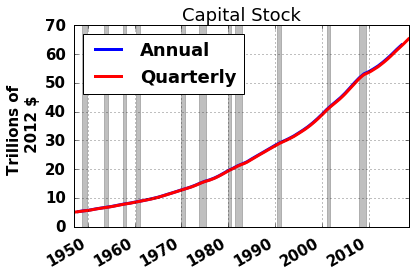

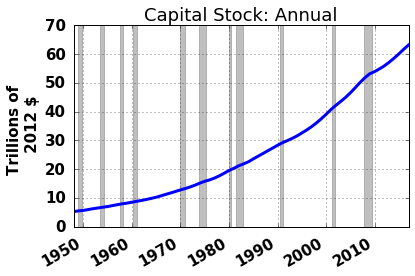

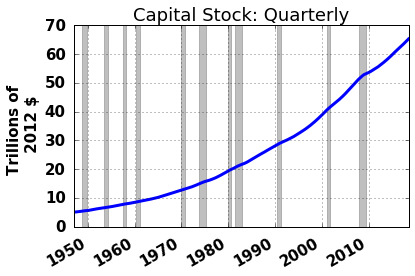

In [7]:
# 5. Plot the capital series. Note that the annual and quarterly series should and do align approximately.

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot_date(capitalA.datetimes,capitalA.data/1000,'b-',lw = 3)
ax.plot_date(capitalQ.datetimes,capitalQ.data/1000,'r-',lw = 3)
ax.xaxis.set_major_locator(years10)
ax.set_ylabel('Trillions of \n '+baseYear+' $')
capitalA.recessions()
fig.autofmt_xdate()
plt.title('Capital Stock')
ax.legend(['Annual','Quarterly'],loc='upper left')
ax.grid(True)
# plt.savefig('fig_US_Production_Capital_QA.png',bbox_inches='tight')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot_date(capitalA.datetimes,capitalA.data/1000,'b-',lw = 3)
ax.xaxis.set_major_locator(years10)
ax.set_ylabel('Trillions of \n '+baseYear+' $')
capitalA.recessions()
fig.autofmt_xdate()
plt.title('Capital Stock: Annual')
ax.grid(True)
# plt.savefig('fig_US_Production_Capital_A.png',bbox_inches='tight')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot_date(capitalQ.datetimes,capitalQ.data/1000,'b-',lw = 3)
ax.xaxis.set_major_locator(years10)
ax.set_ylabel('Trillions of \n '+baseYear+' $')
capitalA.recessions()
fig.autofmt_xdate()
plt.title('Capital Stock: Quarterly')
ax.grid(True)
# plt.savefig('../img/fig_US_Production_Capital_A.png',bbox_inches='tight')

In [8]:
# 6. Save data to csv files

# 6.1 Annual data

YearA       = [a[0:4]     for a in capitalA.dates]
OutputA     = [round(x,1) for x in gdpA.data]
ConsumptionA= [round(x,1) for x in consumptionA.data]
InvestmentA = [round(x,1) for x in investmentA.data]
GovernmentA = [round(x,1) for x in governmentA.data]
ImportsA = [round(x,1) for x in importsA.data]
ExportsA = [round(x,1) for x in exportsA.data]
NetExportsA = [round(x,1) for x in netExportsA.data]
CapitalA    = [round(x,1) for x in capitalA.data]
LaborA      = [round(x,4) for x in laborA.data]

columnsA = ['Year','GDP [Bil. of '+baseYear+' Dollars]','Consumption [Bil. of '+baseYear+' Dollars]','Investment [Bil. of '+baseYear+' Dollars]','Government Purchases [Bil. of '+baseYear+' Dollars]','Exports [Bil. of '+baseYear+' Dollars]','Imports [Bil. of '+baseYear+' Dollars]','Net Exports [Bil. of '+baseYear+' Dollars]','Capital [Bil. of '+baseYear+' Dollars]','Labor [Bil. of Hours]']

df = pd.DataFrame({
    'Year':YearA,
    'GDP [Bil. of '+baseYear+' Dollars]':OutputA,
    'Consumption [Bil. of '+baseYear+' Dollars]':ConsumptionA,
    'Investment [Bil. of '+baseYear+' Dollars]':InvestmentA,
    'Government Purchases [Bil. of '+baseYear+' Dollars]':GovernmentA,
    'Exports [Bil. of '+baseYear+' Dollars]':ExportsA,
    'Imports [Bil. of '+baseYear+' Dollars]':ImportsA,
    'Net Exports [Bil. of '+baseYear+' Dollars]':NetExportsA,
    'Capital [Bil. of '+baseYear+' Dollars]':CapitalA,
    'Labor [Bil. of Hours]':LaborA})
df = df[columnsA]
df.to_csv('../csv/US_Production_A_Data.csv',index=False)

# 6.2 Quarterly data

DateQ     = [a     for a in capitalQ.dates]
OutputQ   = [round(x,1) for x in gdpQ.data]
ConsumptionQ= [round(x,1) for x in consumptionQ.data]
InvestmentQ = [round(x,1) for x in investmentQ.data]
GovernmentQ = [round(x,1) for x in governmentQ.data]
ImportsQ = [round(x,1) for x in importsQ.data]
ExportsQ = [round(x,1) for x in exportsQ.data]
NetExportsQ = [round(x,1) for x in netExportsQ.data]
CapitalQ  = [round(x,1) for x in capitalQ.data]
LaborQ    = [round(x,1) for x in laborQ.data]


columnsQ = ['Date','GDP [Bil. of '+baseYear+' Dollars]','Consumption [Bil. of '+baseYear+' Dollars]','Investment [Bil. of '+baseYear+' Dollars]','Government Purchases [Bil. of '+baseYear+' Dollars]','Exports [Bil. of '+baseYear+' Dollars]','Imports [Bil. of '+baseYear+' Dollars]','Net Exports [Bil. of '+baseYear+' Dollars]','Capital [Bil. of '+baseYear+' Dollars]','Labor [Index: '+laborBaseYear+'=100]']
df = pd.DataFrame({
    'Date':DateQ,
    'GDP [Bil. of '+baseYear+' Dollars]':OutputQ,
    'Consumption [Bil. of '+baseYear+' Dollars]':ConsumptionQ,
    'Investment [Bil. of '+baseYear+' Dollars]':InvestmentQ,
    'Government Purchases [Bil. of '+baseYear+' Dollars]':GovernmentQ,
    'Exports [Bil. of '+baseYear+' Dollars]':ExportsQ,
    'Imports [Bil. of '+baseYear+' Dollars]':ImportsQ,
    'Net Exports [Bil. of '+baseYear+' Dollars]':NetExportsQ,
    'Capital [Bil. of '+baseYear+' Dollars]':CapitalQ,
    'Labor [Index: '+laborBaseYear+'=100]':LaborQ})
df = df[columnsQ]
df.to_csv('../csv/US_Production_Q_Data.csv',index=False)

In [9]:
# 7. Compute the Solow residuals: 

# 7.1 Annual residual
capitalA = capitalA.apc()
tfpA = tfpA.apc()
laborA = laborA.apc()
gdpA = gdpA.apc()
consumptionA = consumptionA.apc()
investmentA = investmentA.apc()
governmentA = governmentA.apc()
exportsA = exportsA.apc()
importsA = importsA.apc()
# netExportsA = netExportsA.apc()

gYA = gdpA.data
gLA = laborA.data
gKA = capitalA.data

tfpA.data = gYA - alpha*gKA - (1-alpha)*gLA

# 7.2. Compute the Solow residual: Quarterly

capitalQ = capitalQ.apc()
tfpQ = tfpQ.apc()
laborQ = laborQ.apc()
gdpQ = gdpQ.apc()
consumptionQ = consumptionQ.apc()
investmentQ = investmentQ.apc()
governmentQ = governmentQ.apc()
exportsQ = exportsQ.apc()
importsQ = importsQ.apc()

netExportsQ.data = np.array(netExportsQ.data)
# netExportsQ = netExportsQ.apc()

gYQ = gdpQ.data
gLQ = laborQ.data
gKQ = capitalQ.data

tfpQ.data = gYQ - alpha*gKQ - (1-alpha)*gLQ

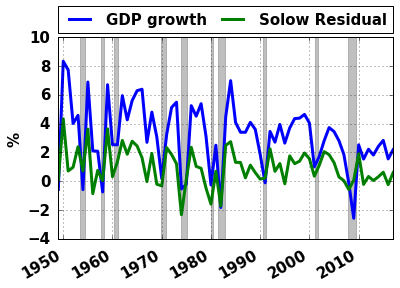

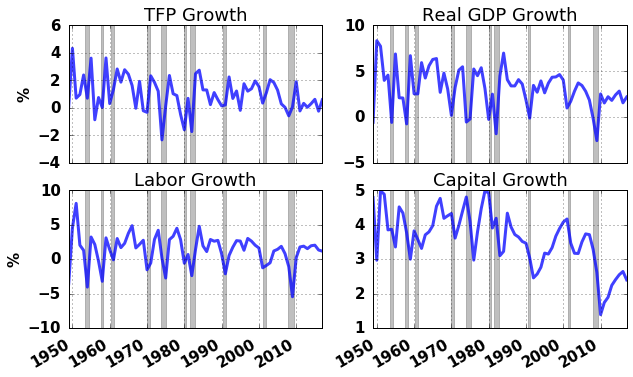

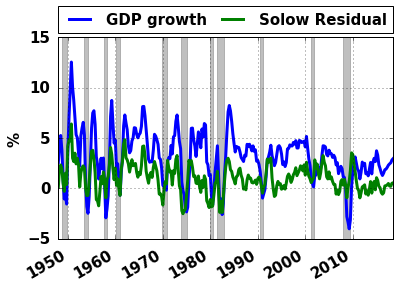

In [10]:
# 11. Construct some plots

fig = plt.figure() 
ax = fig.add_subplot(1,1,1)
ax.plot_date(gdpA.datetimes,gdpA.data,'b-',lw = 3)
ax.plot_date(tfpA.datetimes,tfpA.data,'g-',lw = 3)
ax.xaxis.set_major_locator(years10)
ax.set_ylabel('%')
gdpA.recessions()
fig.autofmt_xdate()
ax.grid(True)
ax.legend(['GDP growth','Solow Residual'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0.,fontsize=15)
# plt.savefig('fig_US_Production_ya_growth_A.png',bbox_inches='tight')

# 11.2 Figure for website: Annual growth in Y, L, K, and A
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(2,2,1)
ax.plot_date(tfpA.datetimes,tfpA.data,'b-',lw = 3,alpha = 0.75)
ax.set_title('TFP Growth')
ax.xaxis.set_major_locator(years10)
ax.set_ylabel('%')
tfpA.recessions()
fig.autofmt_xdate()
ax.locator_params(axis='y',nbins=6)
ax.grid(True)

ax = fig.add_subplot(2,2,2)
ax.plot_date(gdpA.datetimes,gdpA.data,'b-',lw = 3,alpha = 0.75)
ax.set_title('Real GDP Growth')
ax.xaxis.set_major_locator(years10)
ax.locator_params(axis='y',nbins=6)
gdpA.recessions()
fig.autofmt_xdate()
ax.grid(True)

ax = fig.add_subplot(2,2,3)
ax.plot_date(laborA.datetimes,laborA.data,'b-',lw = 3,alpha = 0.75)
ax.xaxis.set_major_locator(years10)
laborA.recessions()
ax.set_ylabel('%')
ax.set_title('Labor Growth')
ax.locator_params(axis='y',nbins=6)
fig.autofmt_xdate()
ax.grid(True)

ax = fig.add_subplot(2,2,4)
ax.plot_date(capitalA.datetimes,capitalA.data,'b-',lw = 3,alpha = 0.75)
ax.xaxis.set_major_locator(years10)
ax.set_title('Capital Growth')
ax.locator_params(axis='y',nbins=6)
capitalA.recessions()
fig.autofmt_xdate()
ax.grid(True)

plt.savefig('../img/fig_US_Production_A_site.png',bbox_inches='tight')


# 11.3 Quarterly GDP growth and the SOlow residual
fig = plt.figure() 
ax = fig.add_subplot(1,1,1)
ax.plot_date(gdpQ.datetimes,gdpQ.data,'b-',lw = 3)
ax.plot_date(tfpQ.datetimes,tfpQ.data,'g-',lw = 3)
ax.xaxis.set_major_locator(years10)
ax.set_ylabel('%')
gdpQ.recessions()
fig.autofmt_xdate()
ax.grid(True)
ax.legend(['GDP growth','Solow Residual'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0.,fontsize=15)
# plt.savefig('../img/fig_US_Production_ya_growth_Q.png',bbox_inches='tight')

In [11]:
# 10. Save growth rate data to csv files

# 10.1 Annual data

YearA     = [a[0:4]     for a in tfpA.dates]
CapitalA  = [round(x,1) for x in capitalA.data]
LaborA    = [round(x,1) for x in laborA.data]
OutputA   = [round(x,1) for x in gdpA.data]
ConsumptionA   = [round(x,1) for x in consumptionA.data]
InvestmentA   = [round(x,1) for x in investmentA.data]
GovernmentA   = [round(x,1) for x in governmentA.data]
ExportsA   = [round(x,1) for x in exportsA.data]
ImportsA   = [round(x,1) for x in importsA.data]
NetExportsA   = [round(x,1) for x in netExportsA.data]


columnsA = ['Year','GDP Growth','Consumption Growth','Investment Growth','Government Purchases Growth','Exports Growth','Imports Growth','Capital Growth','Labor Growth']
data = [YearA,OutputA,ConsumptionA,InvestmentA,GovernmentA,ExportsA,ImportsA,CapitalA,LaborA]
dA ={}
for n,c in enumerate(columnsA):
    dA[columnsA[n]]=data[n]

df = pd.DataFrame(dA)
df = df[columnsA]
df.to_csv('../csv/US_Production_A_Data_Growth_Rates.csv',index=False)


# 10.2 Quarterly data

DateQ     = [a     for a in tfpQ.dates]
CapitalQ  = [round(x,1) for x in capitalQ.data]
LaborQ    = [round(x,1) for x in laborQ.data]
OutputQ   = [round(x,1) for x in gdpQ.data]
ConsumptionQ   = [round(x,1) for x in consumptionQ.data]
InvestmentQ   = [round(x,1) for x in investmentQ.data]
GovernmentQ   = [round(x,1) for x in governmentQ.data]
ExportsQ   = [round(x,1) for x in exportsQ.data]
ImportsQ   = [round(x,1) for x in importsQ.data]
NetExportsQ   = [round(x,1) for x in netExportsQ.data]

columnsQ = ['Year','GDP Growth','Consumption Growth','Investment Growth','Government Purchases Growth','Exports Growth','Imports Growth','Capital Growth','Labor Growth']
data = [DateQ,OutputQ,ConsumptionQ,InvestmentQ,GovernmentQ,ExportsQ,ImportsQ,CapitalQ,LaborQ]
dQ ={}
for n,c in enumerate(columnsQ):
    dQ[columnsQ[n]]=data[n]

df = pd.DataFrame(dQ)
df = df[columnsQ]
df.to_csv('../csv/US_Production_Q_Data_Growth_Rates.csv',index=False)

In [12]:
# 11. Export notebook to python script
progName = 'usProductionData'
runProcs.exportNb(progName)